# Data Analysis - Velib Project in [Python](https://www.python.org/) <a href="https://www.python.org/"><img src="https://s3.dualstack.us-east-2.amazonaws.com/pythondotorg-assets/media/community/logos/python-logo-only.png" style="max-width: 35px; display: inline" alt="Python"/></a>&nbsp;

---
_Authors:_ Amine Aziz Alaoui (<small>IRT St-Exupéry</small>), J. Chevallier (<small>INSA Toulouse</small>), J. Guérin (<small>ANITI</small>), Franck Kouassi (<small>INSA Toulouse</small>), O. Roustant (<small>INSA Toulouse</small>).

We consider the [velib](https://www.velib-metropole.fr/donnees-open-data-gbfs-du-service-velib-metropole) data set, related to the bike sharing system of Paris. The data are loading profiles of the bike stations over one week, collected every hour, from the period Monday 2nd Sept. - Sunday 7th Sept., 2014. The loading profile of a station, or simply loading, is defined as the ratio of number of available bikes divided by the number of bike docks. A loading of 1 means that the station is fully loaded, i.e. all bikes are available. A loading of 0 means that the station is empty, all bikes have been rent.

From the viewpoint of data analysis, the individuals are the stations. The variables are the 168 time steps (hours in the week). **The aim is to detect clusters in the data, corresponding to common customer usages.** This clustering should then be used to predict the loading profile.

---

The aim of this tutorial is to provide you a _starting point for your project_. 
Unsurprisingly, the first step is to get to grips with the dataset by exploring it through easy routines: 
- How are the data coded? 
- How many stations are observed? 
- What is the dispersion of the data? 
- _etc._

You will find some suggested solutions in the "solutions" folder (we can certainly do better). _I can only urge you to first try to answer the questions yourself_, making sure you know which graph to use to answer the question, and then to look in the Python documentation to find out how to make a particular graph (there are lots of resources on the Internet for Python!). The counterpart to this tutorial, but in [R](https://plmlab.math.cnrs.fr/wikistat/Exploration/-/blob/master/Velib/TP_velib_R.ipynb), is also available on wikistat.

In [24]:
import pandas as pd
import numpy as np
import random as rd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from matplotlib.patches import Ellipse

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

%matplotlib inline
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'
OMP_NUM_THREADS=5

## Charger les données

In [3]:
### TO BE COMPLETED ### 
path = 'data/'
loading = pd.read_csv(path+'velibLoading.csv', sep=" ")
loading.head()


,Lun-00,Lun-01,Lun-02,Lun-03,Lun-04,Lun-05,Lun-06,Lun-07,Lun-08,Lun-09,...,Dim-14,Dim-15,Dim-16,Dim-17,Dim-18,Dim-19,Dim-20,Dim-21,Dim-22,Dim-23
1,0.038462,0.038462,0.076923,0.038462,0.038462,0.038462,0.038462,0.038462,0.107143,0.000000,...,0.296296,0.111111,0.111111,0.148148,0.307692,0.076923,0.115385,0.076923,0.153846,0.153846
2,0.478261,0.478261,0.478261,0.434783,0.434783,0.434783,0.434783,0.434783,0.260870,0.043478,...,0.043478,0.000000,0.217391,0.130435,0.045455,0.173913,0.173913,0.173913,0.260870,0.391304
3,0.218182,0.145455,0.127273,0.109091,0.109091,0.109091,0.090909,0.090909,0.054545,0.109091,...,0.259259,0.259259,0.203704,0.129630,0.148148,0.296296,0.314815,0.370370,0.370370,0.407407
4,0.952381,0.952381,0.952381,0.952381,0.952381,0.952381,0.952381,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.904762,0.857143,0.857143,0.857143,0.761905,0.761905,0.761905,0.761905
5,0.927536,0.811594,0.739130,0.724638,0.724638,0.724638,0.724638,0.724638,0.753623,0.971014,...,0.227273,0.454545,0.590909,0.833333,1.000000,0.818182,0.636364,0.712121,0.621212,0.575758


In [4]:
### TO BE COMPLETED ### 
    
coord = pd.read_csv('data/velibCoord.csv', sep=" ")
coord.head()

,longitude,latitude,bonus,names
1,2.377389,48.886300,0,EURYALE DEHAYNIN
2,2.317591,48.890020,0,LEMERCIER
3,2.330447,48.850297,0,MEZIERES RENNES
4,2.271396,48.833734,0,FARMAN
5,2.366897,48.845887,0,QUAI DE LA RAPEE


In [5]:
### TO BE COMPLETED ### 
print('missing data')
loading_missing_value = loading.isna().sum().sort_values(ascending=False) 
print('--- Loading ---')
print(loading_missing_value.sum())

coord_missing_value = coord.isna().sum().sort_values(ascending=False) 
print('--- coord ---')
print(coord_missing_value.sum())
print('---------------------------------')
print('duplicate data')
print('--- Loading ---')
print(loading.duplicated().sum())
print('--- Coord ---')
print(coord.duplicated().sum())

missing data
--- Loading ---
0
--- coord ---
0
---------------------------------
duplicate data
--- Loading ---
0
--- Coord ---
0


In [6]:
data = pd.concat([coord, loading], axis=1)
data = data.rename(columns={data.columns[3]: 'Station'})


cols = data.columns.tolist()


cols.insert(0, cols.pop(cols.index('Station')))
data = data[cols]
start_index = 4  
end_index = 172  
new_column_names = {data.columns[i]: str(i - start_index + 1) for i in range(start_index, end_index)}


data = data.rename(columns=new_column_names)
data.head()

,Station,longitude,latitude,bonus,1,2,3,4,5,6,...,159,160,161,162,163,164,165,166,167,168
1,EURYALE DEHAYNIN,2.377389,48.886300,0,0.038462,0.038462,0.076923,0.038462,0.038462,0.038462,...,0.296296,0.111111,0.111111,0.148148,0.307692,0.076923,0.115385,0.076923,0.153846,0.153846
2,LEMERCIER,2.317591,48.890020,0,0.478261,0.478261,0.478261,0.434783,0.434783,0.434783,...,0.043478,0.000000,0.217391,0.130435,0.045455,0.173913,0.173913,0.173913,0.260870,0.391304
3,MEZIERES RENNES,2.330447,48.850297,0,0.218182,0.145455,0.127273,0.109091,0.109091,0.109091,...,0.259259,0.259259,0.203704,0.129630,0.148148,0.296296,0.314815,0.370370,0.370370,0.407407
4,FARMAN,2.271396,48.833734,0,0.952381,0.952381,0.952381,0.952381,0.952381,0.952381,...,1.000000,1.000000,0.904762,0.857143,0.857143,0.857143,0.761905,0.761905,0.761905,0.761905
5,QUAI DE LA RAPEE,2.366897,48.845887,0,0.927536,0.811594,0.739130,0.724638,0.724638,0.724638,...,0.227273,0.454545,0.590909,0.833333,1.000000,0.818182,0.636364,0.712121,0.621212,0.575758


## Distribution des valeurs dans l'ensemble des données

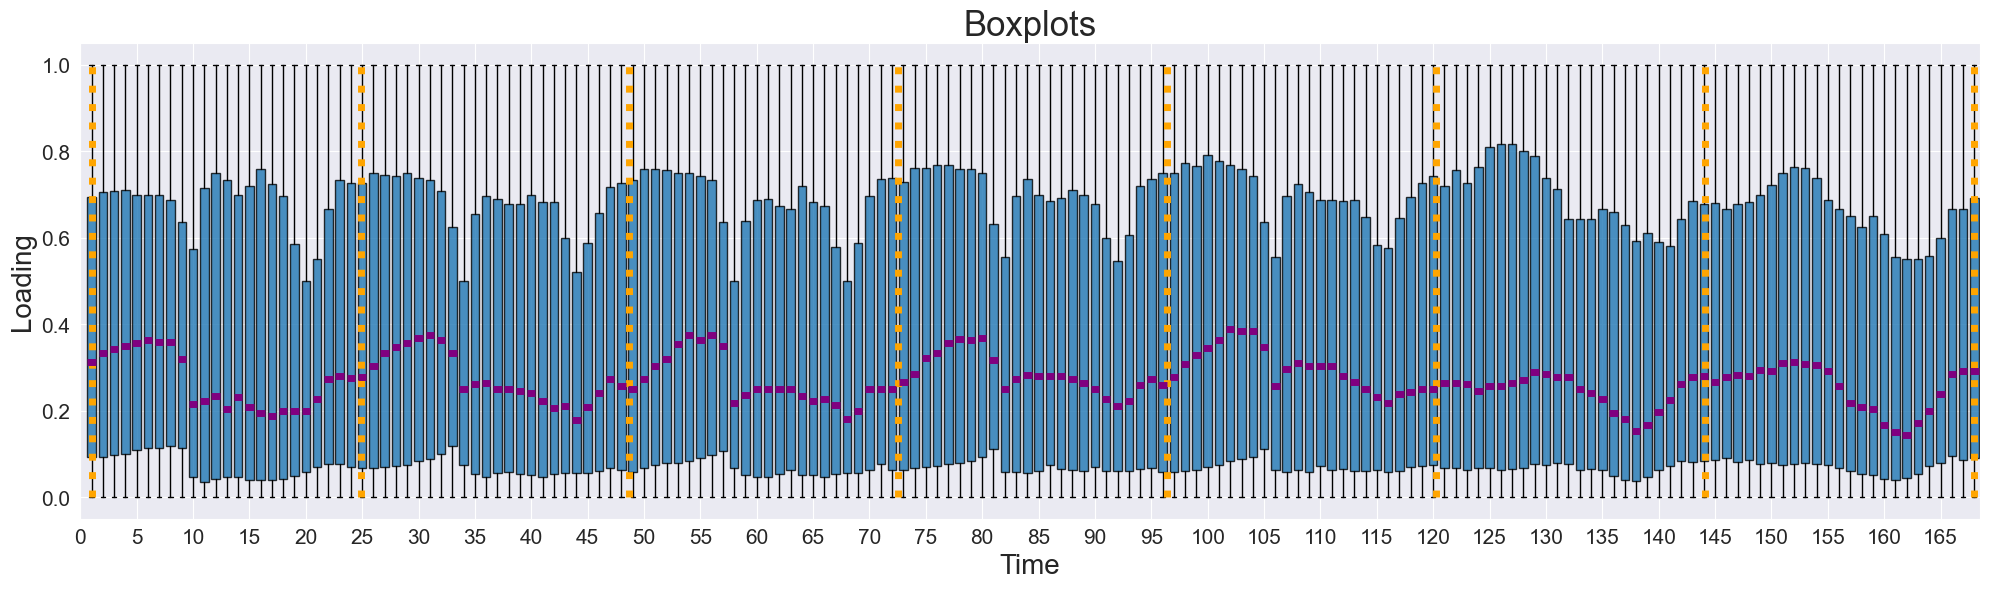

In [10]:
### TO BE COMPLETED ### 
loading_data = loading.to_numpy()
n_steps    = loading.shape[1]
time_tick  = np.linspace(1, n_steps, 8)
plt.figure(figsize = (20,6))
bp = plt.boxplot(loading_data, widths = 0.75, patch_artist = True)

for box in bp['boxes']:
    box.set_alpha(0.8)  
    
for median in bp['medians']:
    median.set(color = "Purple", linewidth=5)
    
plt.vlines(x = time_tick, ymin = 0, ymax = 1, 
           colors = "Orange", linestyle = "dotted", linewidth = 5)

plt.xlabel('Time', fontsize = 20)
plt.ylabel('Loading', fontsize = 20)
plt.title("Boxplots", fontsize = 25)

plt.xticks(ticks = np.arange(0, 168, 5), labels=np.arange(0, 168, 5), fontsize = 15)
plt.yticks(fontsize = 15)

plt.tight_layout()
plt.show()

## Chargement moyen

--- Average fill rate ---
0.3816217759807477

--- Least crowded station, on average ---
 HORNET (BAGNOLET)
0.016132842025699153

--- Fullest station, on average ---
 INSURRECTION AOUT 1944 (IVRY)
0.9193722943722953


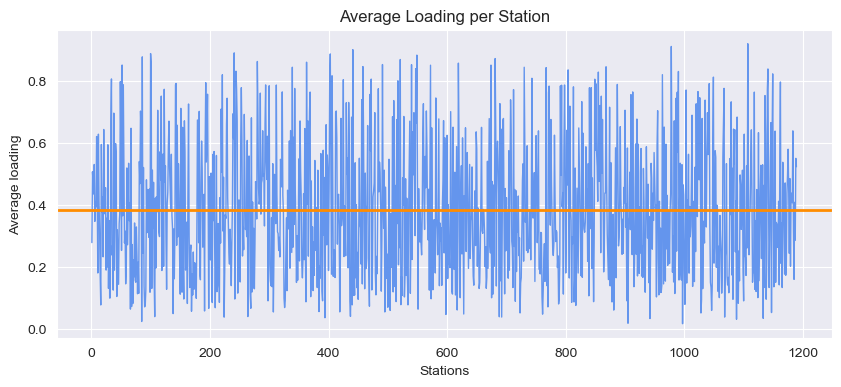

In [11]:
average_fill_rate = loading.mean().mean()
print('--- Average fill rate ---')
print(average_fill_rate)


least_crowded_station = loading.mean(axis=1).idxmin() 
print('\n--- Least crowded station, on average ---')
print(coord.iloc[least_crowded_station-1,3])
print(loading.mean(axis=1)[least_crowded_station])


fullest_station = loading.mean(axis=1).idxmax()  
print('\n--- Fullest station, on average ---')
print(coord.iloc[fullest_station-1,3])
print(loading.mean(axis=1)[fullest_station])


df = pd.DataFrame({
    'stations': np.arange(1, len(loading) + 1),  
    'mean': loading.mean(axis=1) 
})

plt.figure(figsize=(10, 4))
plt.plot(df['stations'], df['mean'], color='cornflowerblue', linewidth=1)  
plt.axhline(y=average_fill_rate, color='darkorange', linewidth=2)  
plt.xlabel('Stations')
plt.ylabel('Average loading')
plt.title('Average Loading per Station')
plt.show()

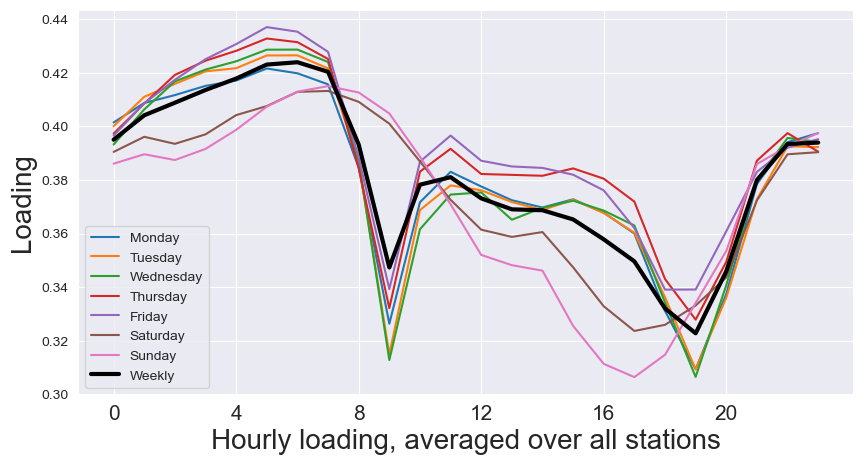

In [12]:
loading_mean = pd.Series(loading.mean(axis=1))
mean_per_hour_per_day = loading.mean(axis = 0).to_numpy()
mean_per_hour_per_day = mean_per_hour_per_day.reshape((7, 24))

mean_per_hour = mean_per_hour_per_day.mean(axis=0)

# --- #

days = ["Monday", "Tuesday", "Wednesday","Thursday", "Friday", "Saturday", "Sunday"]
plt.figure(figsize = (10,5))

plt.plot(mean_per_hour_per_day.transpose())
plt.plot(mean_per_hour, color = "black", linewidth = 3)

plt.xlabel('Hourly loading, averaged over all stations', fontsize = 20)
plt.ylabel('Loading', fontsize = 20)
plt.legend(days + ['Weekly'])
plt.xticks(ticks = np.arange(0,24,4), labels=np.arange(0,24,4), fontsize = 15)
  
plt.tight_layout
plt.show()

## PCA

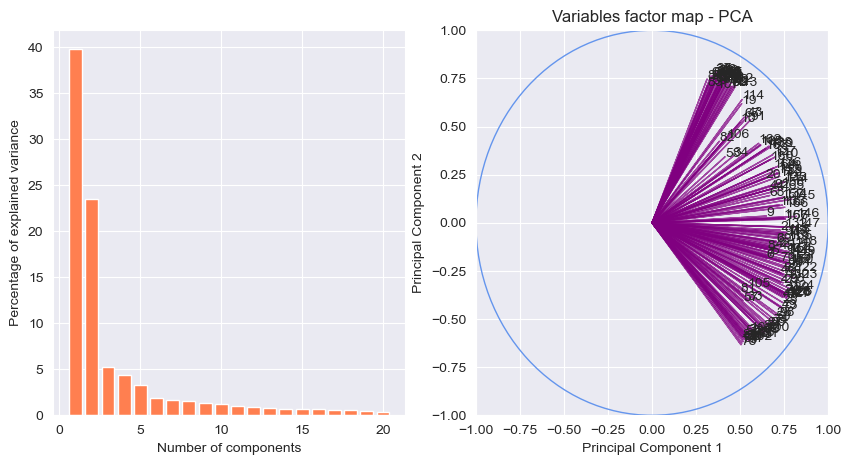

In [13]:
data_scale = data.copy()
ss = StandardScaler()
data_scale.iloc[:, 4:] = ss.fit_transform(data.iloc[:, 4:])
pca = PCA()
pca_result = pca.fit_transform(data_scale.iloc[:, 4:])
explained_variance_ratio = 100 * pca.explained_variance_ratio_
n_bars = 20


fig, axs = plt.subplots(1, 2, figsize=(10, 5))


axs[0].bar(np.arange(1, n_bars + 1), explained_variance_ratio[:n_bars], color='coral')
axs[0].set_xlabel("Number of components")
axs[0].set_ylabel("Percentage of explained variance")


coord1 = pca.components_[0] * np.sqrt(pca.explained_variance_[0])
coord2 = pca.components_[1] * np.sqrt(pca.explained_variance_[1])


for i, j, nom in zip(coord1, coord2, data.columns[4:172]):
    axs[1].text(i, j, nom, fontsize=10)
    axs[1].arrow(0, 0, i, j, color='purple', alpha=0.7, width=0.0001)


axs[1].set_xlim(-1, 1)
axs[1].set_ylim(-1, 1)
axs[1].add_artist(plt.Circle((0, 0), radius=1, color='cornflowerblue', fill=False))


axs[1].set_title('Variables factor map - PCA')
axs[1].set_xlabel('Principal Component 1')
axs[1].set_ylabel('Principal Component 2')

# Hiển thị grid
axs[1].grid(True)

# Hiển thị hình
plt.show()

In [19]:
def plot_point_cov(points, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma ellipse based on the mean and covariance of a point
    "cloud" (points, an Nx2 array).

    Parameters
    ----------
        points : An Nx2 array of the data points.
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

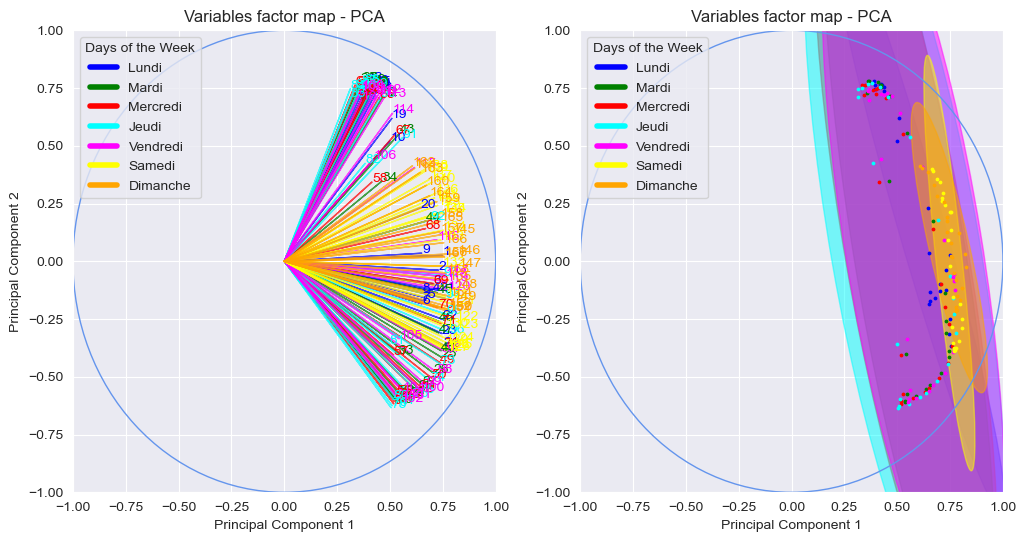

In [20]:
day_colors = {
    'Lundi': 'blue',
    'Mardi': 'green',
    'Mercredi': 'red',
    'Jeudi': 'cyan',
    'Vendredi': 'magenta',
    'Samedi': 'yellow',
    'Dimanche': 'orange',
}


day_ranges = {
    'Lundi': range(1, 25),
    'Mardi': range(25, 49),
    'Mercredi': range(49, 73),
    'Jeudi': range(73, 97),
    'Vendredi': range(97, 121),
    'Samedi': range(121, 145),
    'Dimanche': range(145, 169),
}
fig, axs = plt.subplots(1, 2, figsize=(12, 6))


ax1 = axs[0]
for i, j, nom in zip(coord1, coord2, data.columns[4:172]):
    nom_value = int(nom)

    for day, col_range in day_ranges.items():
        if nom_value in col_range:
            color = day_colors[day]
            break
    
    ax1.text(i, j, nom, fontsize=10, color=color)
    ax1.arrow(0, 0, i, j, color=color, alpha=0.7, width=0.0001)


ax1.axis((-1, 1, -1, 1))
ax1.add_artist(plt.Circle((0, 0), radius=1, color='cornflowerblue', fill=False))
ax1.set_title('Variables factor map - PCA')
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
ax1.grid(True)


legend_elements = [plt.Line2D([0], [0], color=color, lw=4, label=day) for day, color in day_colors.items()]
ax1.legend(handles=legend_elements, loc='upper left', title='Days of the Week')


ax2 = axs[1]
for day, col_range in day_ranges.items():
    day_coord1 = coord1[col_range.start - 1: col_range.stop - 1]
    day_coord2 = coord2[col_range.start - 1: col_range.stop - 1]
    points = np.column_stack((day_coord1, day_coord2))
    color = day_colors[day]
    plot_point_cov(points, nstd=3, alpha=0.5, color=color)
    
for i, j, nom in zip(coord1, coord2, data.columns[4:172]):
    nom_value = int(nom)
    for day, col_range in day_ranges.items():
        if nom_value in col_range:
            color = day_colors[day]
            break
    ax2.scatter(i, j, c=color, s=3)


ax2.axis((-1, 1, -1, 1))
ax2.add_artist(plt.Circle((0, 0), radius=1, color='cornflowerblue', fill=False))
ax2.set_title('Variables factor map - PCA')
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')
ax2.grid(True)


legend_elements = [plt.Line2D([0], [0], color=color, lw=4, label=day) for day, color in day_colors.items()]
ax2.legend(handles=legend_elements, loc='upper left', title='Days of the Week')



plt.show()

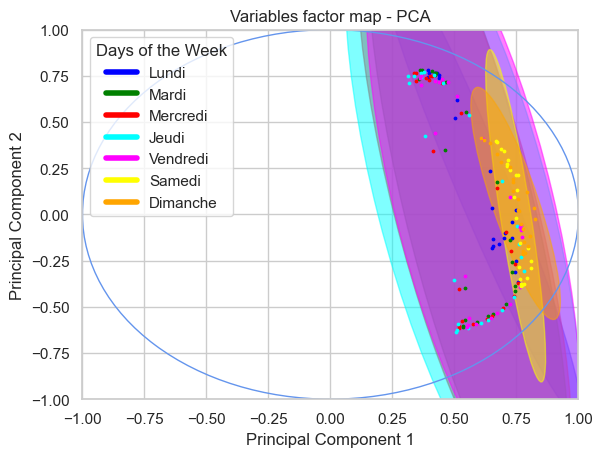

In [148]:


for day, col_range in day_ranges.items():

    day_coord1 = coord1[col_range.start - 1: col_range.stop - 1]
    day_coord2 = coord2[col_range.start - 1: col_range.stop - 1]
    

    points = np.column_stack((day_coord1, day_coord2))
    
    color = day_colors[day]
    
    plot_point_cov(points, nstd=3, alpha=0.5, color=color)
for i, j, nom in zip(coord1, coord2, data.columns[4:172]):
    nom_value = int(nom)
    
    for day, col_range in day_ranges.items():
        if nom_value in col_range:
            color = day_colors[day]
            break
    

    plt.scatter(i, j, c=color, s=3)



plt.axis((-1, 1, -1, 1))
plt.gcf().gca().add_artist(plt.Circle((0, 0), radius=1, color='cornflowerblue', fill=False))

plt.title('Variables factor map - PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
legend_elements = [plt.Line2D([0], [0], color=color, lw=4, label=day) for day, color in day_colors.items()]

plt.legend(handles=legend_elements, loc='upper left', title='Days of the Week')

plt.grid(True)
plt.show()

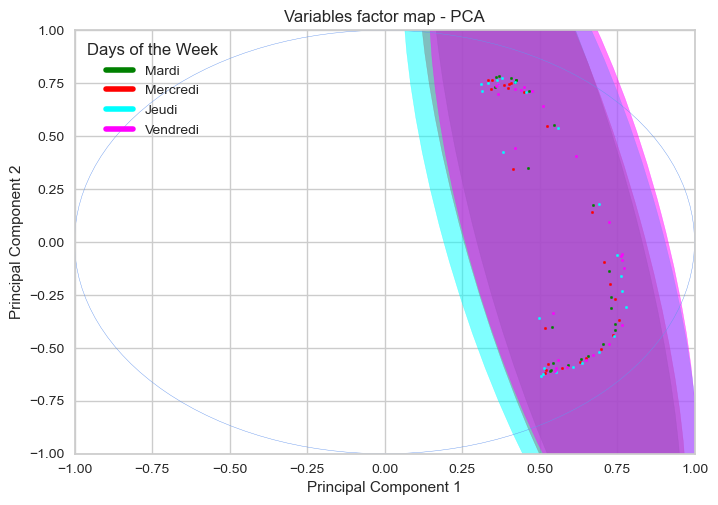

In [26]:
filtered_day_ranges = {day: col_range for day, col_range in day_ranges.items() if day in ['Mardi', 'Mercredi', 'Jeudi', 'Vendredi']}
ax2 = axs[1]
for day, col_range in filtered_day_ranges.items():
    day_coord1 = coord1[col_range.start - 1: col_range.stop - 1]
    day_coord2 = coord2[col_range.start - 1: col_range.stop - 1]
    

    points = np.column_stack((day_coord1, day_coord2))
    

    color = day_colors[day]
    

    plot_point_cov(points, nstd=3, alpha=0.5, color=color)
    

for i, j, nom in zip(coord1[24:120], coord2[24:120], data.columns[28:124]):
    nom_value = int(nom)

    for day, col_range in filtered_day_ranges.items():
        if nom_value in col_range:
            color = day_colors[day]
            break
    

    plt.scatter(i, j, c=color, s=3)


plt.axis((-1, 1, -1, 1))
plt.gcf().gca().add_artist(plt.Circle((0, 0), radius=1, color='cornflowerblue', fill=False))
plt.title('Variables factor map - PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)


legend_elements = [plt.Line2D([0], [0], color=color, lw=4, label=day) for day, color in day_colors.items() if day in ['Mardi', 'Mercredi', 'Jeudi', 'Vendredi']]
plt.legend(handles=legend_elements, loc='upper left', title='Days of the Week')


plt.show()


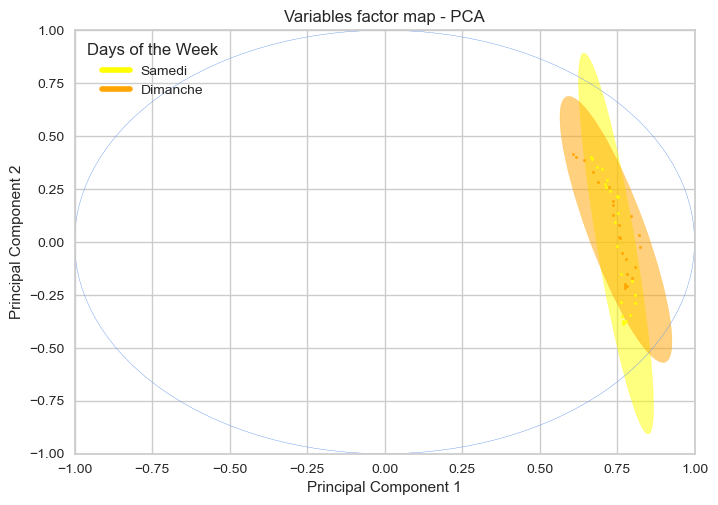

In [27]:
filtered_day_ranges = {day: col_range for day, col_range in day_ranges.items() if day in ['Samedi', 'Dimanche']}
ax2 = axs[1]

for day, col_range in filtered_day_ranges.items():
    day_coord1 = coord1[col_range.start - 1: col_range.stop - 1]
    day_coord2 = coord2[col_range.start - 1: col_range.stop - 1]
    

    points = np.column_stack((day_coord1, day_coord2))
    

    color = day_colors[day]
    

    plot_point_cov(points, nstd=3, alpha=0.5, color=color)

for i, j, nom in zip(coord1[120:168], coord2[120:168], data.columns[124:172]):
    nom_value = int(nom)

    for day, col_range in filtered_day_ranges.items():
        if nom_value in col_range:
            color = day_colors[day]
            break
    

    plt.scatter(i, j, c=color, s=3)


plt.axis((-1, 1, -1, 1))
plt.gcf().gca().add_artist(plt.Circle((0, 0), radius=1, color='cornflowerblue', fill=False))
plt.title('Variables factor map - PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)


legend_elements = [plt.Line2D([0], [0], color=color, lw=4, label=day) for day, color in day_colors.items() if day in ['Samedi', 'Dimanche']]
plt.legend(handles=legend_elements, loc='upper left', title='Days of the Week')


plt.show()


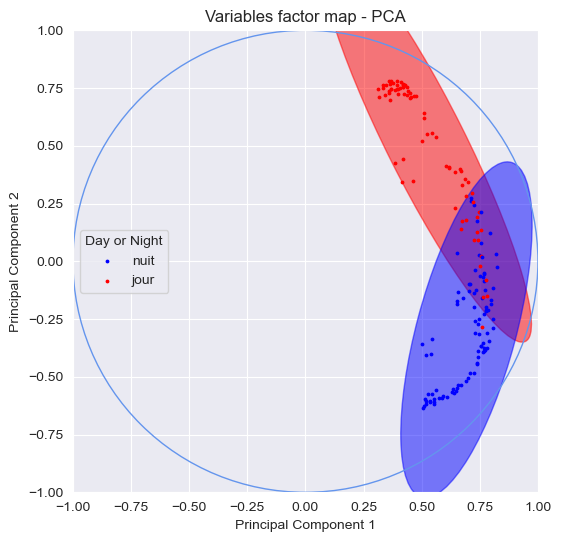

In [23]:



plt.figure(figsize=(6, 6))

jour_label_added = False
nuit_label_added = False


indices = np.arange(len(coord1))
mask = (indices % 24 >= 9) & (indices % 24 <= 19)


day_coord1 = coord1[mask]

day_coord2 = coord2[mask]    
points = np.column_stack((day_coord1, day_coord2))
plot_point_cov(points, nstd=3, alpha=0.5, color='red')
day_coord1 = coord1[~mask]

day_coord2 = coord2[~mask]    
points = np.column_stack((day_coord1, day_coord2))
plot_point_cov(points, nstd=3, alpha=0.5, color='blue')
for i, j, nom in zip(coord1, coord2, data.columns[4:172]):
    nom_value = int(nom)
    remainder = nom_value % 24  

    if 10 <= remainder <= 20:
        if not jour_label_added:
            plt.scatter(i, j, label='jour', color='red', s=3)
            jour_label_added = True  
        else:
            plt.scatter(i, j, color='red', s=3)
    else:
        if not nuit_label_added:
            plt.scatter(i, j, label='nuit', color='blue', s=3)
            nuit_label_added = True  
        else:
            plt.scatter(i, j, color='blue', s=3)


plt.axis((-1, 1, -1, 1))
plt.gca().add_artist(plt.Circle((0, 0), radius=1, color='cornflowerblue', fill=False))

plt.title('Variables factor map - PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')


plt.legend(title='Day or Night')

plt.grid(True)
plt.show()

## Clustering avec K-means:

C:\Users\nam\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\nam\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\nam\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\nam\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with M

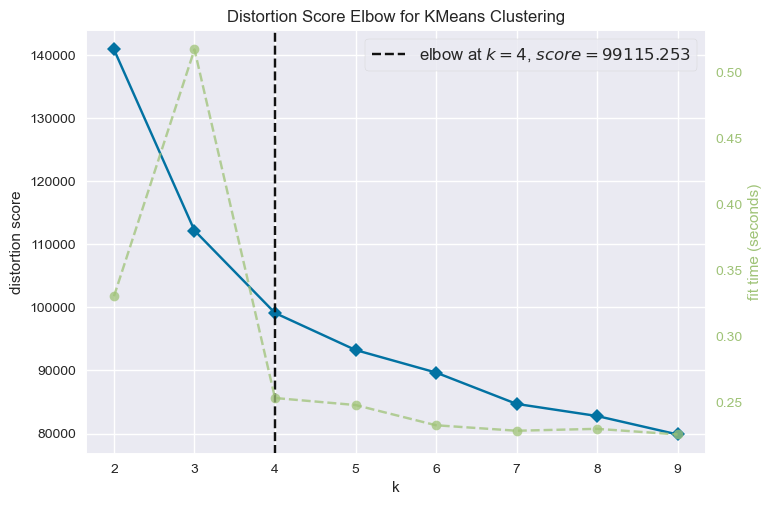

C:\Users\nam\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\nam\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\nam\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\nam\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with M

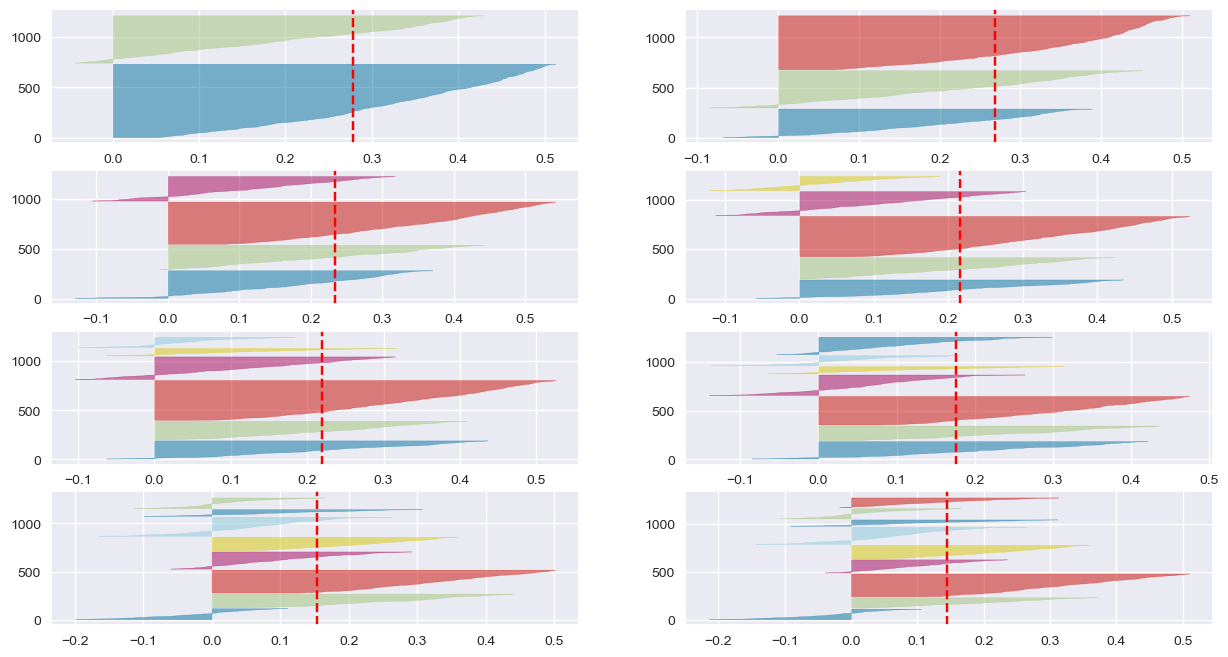

In [38]:
kmeans = KMeans(init='k-means++', n_init='auto', max_iter=100, random_state=42)
visualizer = KElbowVisualizer(kmeans, k=(2,10))

visualizer.fit(data_scale.iloc[:, 4:])
visualizer.show()

fig, ax = plt.subplots(4, 2, figsize=(15,8))

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init='auto', max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    

    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(data_scale.iloc[:, 4:])

##### <span style="color:purple"> **Question:** Where are the velib stations located?</span>

- Plot the stations coordinates on a 2D map (latitude _vs._ longitude)
- Use the average hourly loading as a color scale
- You can consider different times of day, for example 6am, 12pm, 11pm on Monday, or the average weekly load at 6am.
- You can consider different days at the same time, or the average load for each day.
- You can use the [`scatter_mapbox`](https://plotly.com/python/scattermapbox/) function of the [`plotly.express`](https://plotly.com/python/plotly-express/) to charge the map of Paris

In [ ]:
### TO BE COMPLETED ### 
## Simple 2D representation
# Monday at hour 6h, 12h, 23h

# Hours to be displayed
hours = ...

# --- #

[...]

In [ ]:
# %load solutions/Python/plot_loading_2D_monday.py

> Comments?

In [ ]:
### TO BE COMPLETED ### 
## Simple 2D representation
# Loading at 6pm, depending on the day of the week

[...]

In [ ]:
# %load solutions/Python/plot_loading_2D_18h.py

> Comments?

In [ ]:
### TO BE COMPLETED ### 
## Visualization on the Paris map

[...]

In [ ]:
# %load solutions/Python/plot_loading_map.py

> Comments?

## Influence of Altitude Difference on Station Loading

##### <span style="color:purple"> **Question:** Does Paris have many hilltop stations?</span>

- Compare the number of hilltop stations with the others.

In [ ]:
loading_hill = ...

[...]

In [ ]:
# %load solutions/Python/hilltop_stations.py

##### <span style="color:purple"> **Question:** Are hilltop stations more crowded than others?</span>

- Plot the stations coordinates on a 2D map (latitude _vs._ longitude), using a different color for stations which are located on a hill.
- Redo the initial study, but distinguish hilltop stations from others.

In [ ]:
### TO BE COMPLETED ### 
## Simple 2D representation

[...]

In [ ]:
# %load solutions/Python/hilltop_stations_2D.py

In [ ]:
### TO BE COMPLETED ### 
## Visualization on the Paris map

coord['hill'] = coord['bonus'].astype('category') # convert to categorical

[...]

In [ ]:
# %load solutions/Python/hilltop_stations_map.py